In [157]:
import pickle
import imageio
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from graphviz import Digraph
import pydot

from tqdm import tqdm

import numpy as np
import os
from os import listdir

## Adjust CSV

In [124]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


In [131]:
train_df.species.unique()
len(train_df.species.unique())

26

In [125]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Load images

In [108]:
#Training Data
MAX_SIZE = 64
dataset = []
for i,img in enumerate(tqdm(images)):
    image = cv2.imread("train_images/"+img,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    #dataset.append((image,sid[i]))
    dataset.append(image)


100%|████████████████████████████████████████████████████████████████████████████| 51033/51033 [19:28<00:00, 43.66it/s]


In [38]:
#Testing Data
test_dir = "test_images"
test_dataset = []
for img in tqdm(os.listdir(test_dir)): 
    image = imageio.imread("test_images/"+img)
    image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    test_dataset.append(image)

  1%|▋                                                                             | 261/27956 [00:11<19:45, 23.37it/s]


KeyboardInterrupt: 

In [162]:
X = []
Y = []
for i, image in enumerate(dataset):
    X.append(image)
    Y.append(train_df["species"][i])

#new_X = []
#for i in range(64):
#    for j in range(64):
#        new_X.append((X[i][j][0],X[i][j][1],X[i][j][2]))
    
X = np.array(X)
Y = np.array(Y)

X_valid, X_train = X[:5000] / 255.0, X[5000:] / 255.0
y_valid, y_train = Y[:5000], Y[5000:]
#X_test = test_dataset / 255.0

#save_label = open("base_test.pickle","wb")
#pickle.dump(label, save_label)
#save_label.close()

## Modelling

In [172]:
#generating model
model = keras.Sequential([
    layers.Flatten(input_shape=[64, 64]),
    #layers.Dense(512, activation="relu"),
    #layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(26, activation="softmax"),
])
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 4096)              0         
                                                                 
 dense_42 (Dense)            (None, 512)               2097664   
                                                                 
 dense_43 (Dense)            (None, 256)               131328    
                                                                 
 dense_44 (Dense)            (None, 128)               32896     
                                                                 
 dense_45 (Dense)            (None, 64)                8256      
                                                                 
 dense_46 (Dense)            (None, 26)                1690      
                                                                 
Total params: 2,271,834
Trainable params: 2,271,834
N

In [173]:
#compiling model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [174]:
X_train.shape

(46033, 64, 64)

In [175]:


#training model
epochs = 20
history = model.fit(X_train, y_train, epochs=epochs,
                    validation_data=(X_valid, y_valid))
#saving trained model
with open('base_model.pkl','wb') as f:
    pickle.dump(model,f)

Epoch 1/20
1439/1439 [==============================] - 12s 8ms/step - loss: 2.0594 - sparse_categorical_accuracy: 0.3855 - val_loss: 1.8992 - val_sparse_categorical_accuracy: 0.4346
Epoch 2/20
1439/1439 [==============================] - 12s 8ms/step - loss: 1.7940 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.7809 - val_sparse_categorical_accuracy: 0.4686
Epoch 3/20
1439/1439 [==============================] - 13s 9ms/step - loss: 1.6832 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.7504 - val_sparse_categorical_accuracy: 0.4866
Epoch 4/20
1439/1439 [==============================] - 12s 8ms/step - loss: 1.6088 - sparse_categorical_accuracy: 0.5165 - val_loss: 1.6479 - val_sparse_categorical_accuracy: 0.4982
Epoch 5/20
1439/1439 [==============================] - 12s 8ms/step - loss: 1.5534 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.6639 - val_sparse_categorical_accuracy: 0.4950
Epoch 6/20
1439/1439 [==============================] - 12s 8ms/step - loss: 1.5119 -

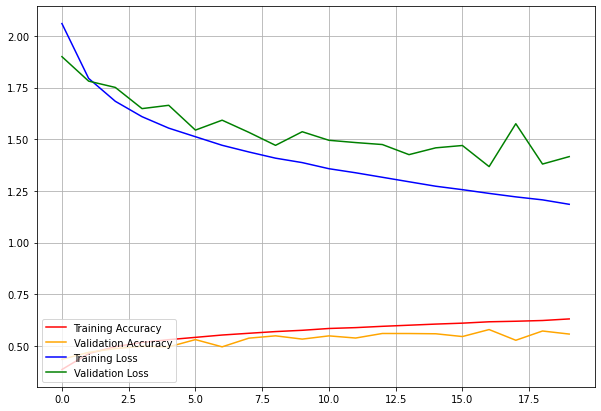

In [176]:
#visualize model performance
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(range(epochs), accuracy, "r", label="Training Accuracy")
plt.plot(range(epochs), val_accuracy, "orange", label="Validation Accuracy")
plt.plot(range(epochs), loss, "b", label="Training Loss")
plt.plot(range(epochs), val_loss, "g", label="Validation Loss")
plt.legend(loc="lower left")
#plt.gca().set_ylim(0, 2)
plt.grid(True)

plt.show()

In [179]:
#evaluate model
model.evaluate(X_train, y_train)

1439/1439 [==============================] - 5s 3ms/step - loss: 1.1788 - sparse_categorical_accuracy: 0.6298


[1.178846836090088, 0.6298090219497681]

## Predicting

In [66]:
if model not in globals():
    model = pickle.load(open('base_model.pkl', 'rb'))
    
X_new = X_test
y_proba = model.predict(X_new)


IndentationError: expected an indented block after 'else' statement on line 4 (1323928857.py, line 4)